In [11]:
import torch
import random
import numpy as np
'''
Мы хотим чтобы эксперименты были воспроизводимы: 
чтобы, взяв один и тот же питоновский файл и выполнив его, мы получили бы тот же самый результат, как и раньше. 

Например, это нужно для того чтобы понимать: 
а правда ли те изменения, которые мы делаем с нейросетью, улучшают наши результаты, или это результат некоторой случайности.

Поэтому мы хотем зафиксировать случайные числа, чтобы мы получили один и тот же 
результат что и раньше
'''

# .seed - номер последовательности случайных чисел, которую выдаст нам случайный генератор, если его попросить выдать нам последовательность.
random.seed(0) # python
np.random.seed(0) # numpy
torch.manual_seed(0) # torch
torch.cuda.manual_seed(0) # cpu and gpu 
torch.backends.cudnn.deterministic = True

In [12]:
import sklearn.datasets
wine = sklearn.datasets.load_wine() # популярная библиотека вин
wine.data.shape
# 178 примеров, 13 параметров

(178, 13)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], # для удобства визуализации
    wine.target,      # то что нам нужно предсказать
    test_size=0.3,    # 30% на тест
    shuffle=True)     # перемешать

# оборачиваем массивы в тензоры
X_train = torch.FloatTensor(X_train)  
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [16]:
# нейросеть для классификации
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
# Softmax - функция активации, т.е. выходит 3 нейрона, каждый с 1 выходным y. 
# Эти 3 y проходят через SoftMax и на выходе мы получаем вероятности и  классов
        
    def forward(self, x): # граф нахей нейронной сети
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x) 
        return x 
# Для подсчена кросс-энтропии нам не нужно считать Softmax, так как 
# Кросс-энтропия: есть log ; Softmax: есть exp . 
# exp и log взаимоуничтожаются и получается, что не нужно вычислять exp чтобы посчитать кросс-энтропю

    def inference(self, x): # для вычисления веростность
        x = self.forward(x)
        x = self.sm(x)      # Softmax
        return x
    
wine_net = WineNet(5)

In [17]:
loss = torch.nn.CrossEntropyLoss() 
# использует выходи из net, не пропущенные через Softmax

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [18]:
'''
В реальной жизни вряд ли поместится в памяти весь датасет. 
То есть, обучение в реальной жизни происходит по частям данных -- они называются батчи (batch).
Мы должны отрезать некоторый кусочек наших данных, посчитать по нему loss, посчитать по нему градиентный шаг,
сделать градиентный шаг, взять следующий кусочек, и так далее, вот так этот процесс проделывать.

Соответственно, одна эпоха, то есть итерация просмотра всего датасета, у нас бьётся на много маленьких частей.
'''
np.random.permutation(5)

array([4, 1, 2, 3, 0])

In [32]:
batch_size = 10 # сколько элементов в одном батче. Можно взять любое другое число

for epoch in range(5000):
    order = np.random.permutation(len(X_train)) # отвечает за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) # пропусчаем batch через net. Без softmax
        
        loss_value = loss(preds, y_batch) # посчитаем loss функци.
        loss_value.backward() # У результата выполнения loss функции посчитаем производную 
        
        optimizer.step() # а рез. производной закидываются в optimizer для совершения градиентного шага
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())
        # print(test_preds)
        # print(test_preds)
        # print(y_test)

# чтобы понять, какой класс предсказывает нейросеть, не обязательно вычислять софтмакс, 
# не обязательно вычислять вероятности. Достаточно посмотреть, какой выход был наибольшим


tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8148)
tensor(0.8704)
tensor(0.8704)


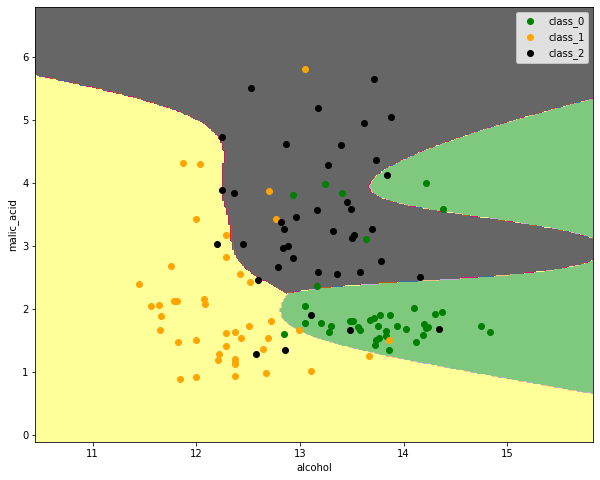

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

In [9]:
import random
random.seed(8)
print(random.randint(0, 10))


3
